## Disclaimer

The Python scripts and the Jupyter Notebook (`vignette.ipynb`) in this repository are developed for extreme value statistical analysis.

Users are encouraged to refer to the accompanying paper for detailed method explanations and applications of these functions.

All bug reports and feature requests are welcomed.

The scripts are licensed under the GNU Lesser General Public License Version 3 (LGPL-3.0).

(# TODO: add proper paper citation)

`unibm`

> `cdf_func_kernel` non parametric cdf estimator, by kernel smoothing
>
> `est_tail_dep_coeff` pairwise tail dependence coefficient estimator
>
> `est_extremal_index_reciprocal` extremal index (EI) estimator, by reciprocal of the mean of the block maxima;
>
> `viz_eir` chart results from `est_extremal_index_reciprocal(is_retn_vec=True)`
>
> `est_extreme_value_index` extreme value index (EVI) estimator, by MPMR & EMR
>
> `viz_evi_reg` chart results from `est_extreme_value_index(is_retn_vec=True)`


## Dependencies

> modules listed in `requirements.txt`


In [ ]:
%pip install --user -r requirements.txt

## (half) Student's T & Gaussian, extreme value index


In [11]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, t

from unibm import (
    est_extremal_index_reciprocal,
    est_extreme_value_index,
    viz_eir,
    viz_evi_reg,
)

DIR_DATA = Path("./data")
DIR_OUT = Path("./out")

C:\Users\tycheng\AppData\Local\Temp\ipykernel_34020\2253521465.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


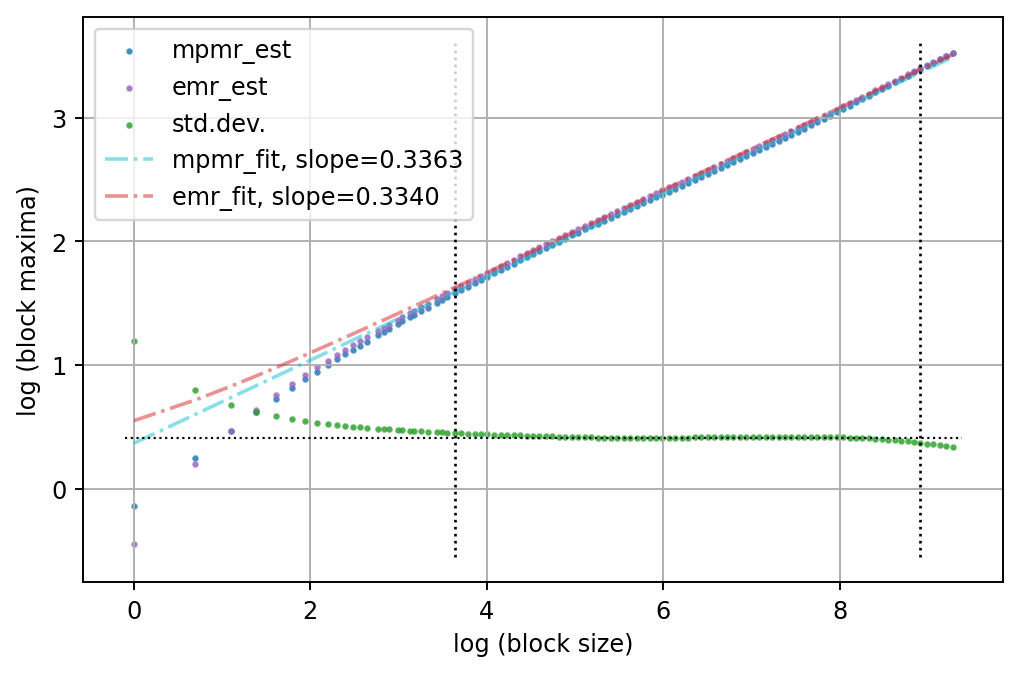

In [12]:
# (half) Student's T, EVI
np.random.seed(5)
vec = np.abs(t.rvs(df=3, size=(50000,)))
dct_res_evi = est_extreme_value_index(
    vec=vec, is_retn_vec=True, is_deming=False, delta=0.1, is_geom=None
)
viz_evi_reg(
    dct_res=dct_res_evi,
    file_path=DIR_OUT / "evi_studentt.png",
    is_save=False,
    is_gaussian=False,
)

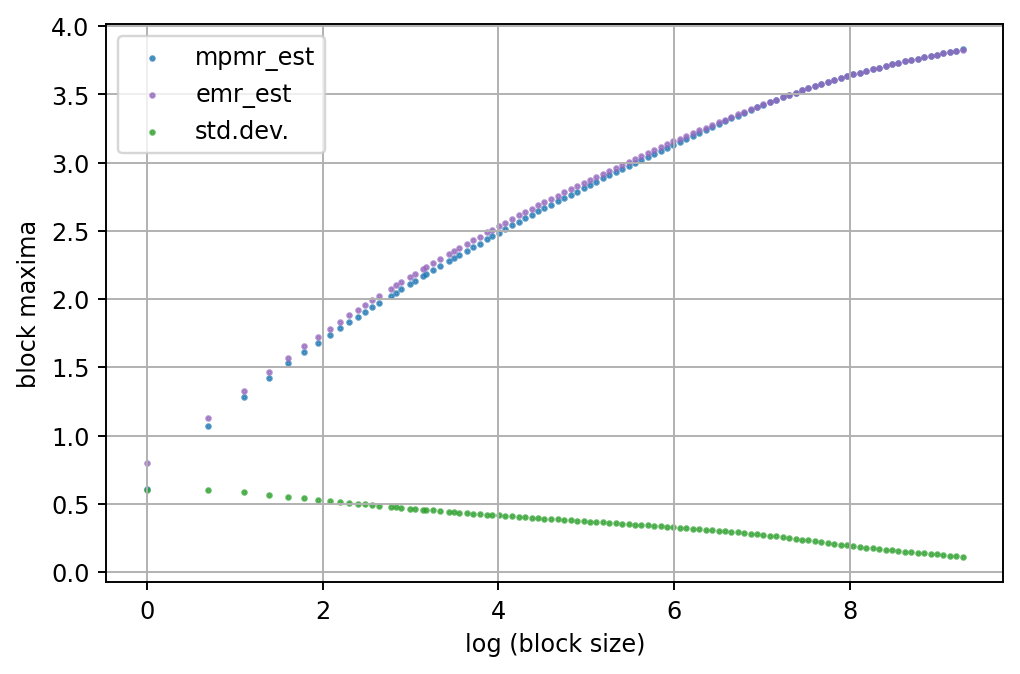

In [13]:
# (half) Gaussian, EVI
np.random.seed(5)
vec = np.abs(norm.rvs(size=(50000,)))
dct_res_evi = est_extreme_value_index(
    vec=vec,
    is_retn_vec=True,
    is_deming=False,
    # delta=0.21,
    is_geom=None,
    is_frechet=False,
)
viz_evi_reg(
    dct_res_evi,
    file_path=DIR_OUT / "evi_gaussian.png",
    is_save=False,
    is_gaussian=True,
)

## Meteorite landing mass


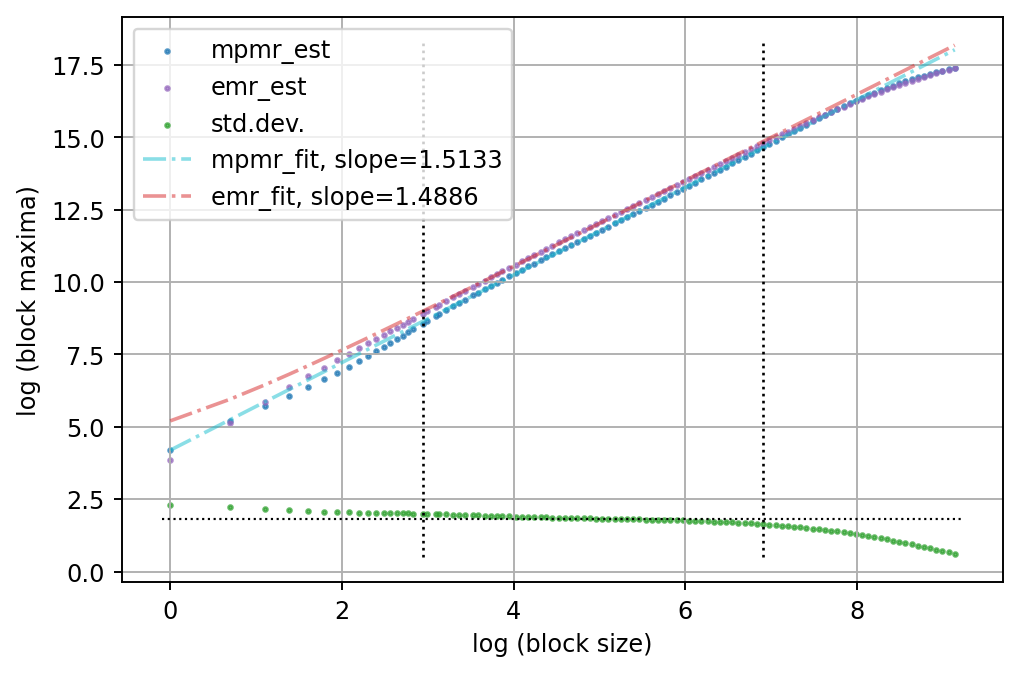

In [13]:
srs_meteorite = pd.read_csv(DIR_DATA / "Meteorite_Landings.csv").drop_duplicates()
srs_meteorite = srs_meteorite[srs_meteorite.fall == "Found"]
srs_meteorite.index = srs_meteorite.id
srs_meteorite = srs_meteorite["mass (g)"].squeeze().dropna().sort_values()
vec = srs_meteorite[srs_meteorite > 1].values
dct_res_evi = est_extreme_value_index(
    vec=vec, is_retn_vec=True, is_geom=None, delta=0.1
)
viz_evi_reg(
    dct_res=dct_res_evi,
    file_path=DIR_OUT / "evi_meteorite.png",
    is_save=False,
)

## Earthquake, USGS


Text(0.5, 0, 'Date')

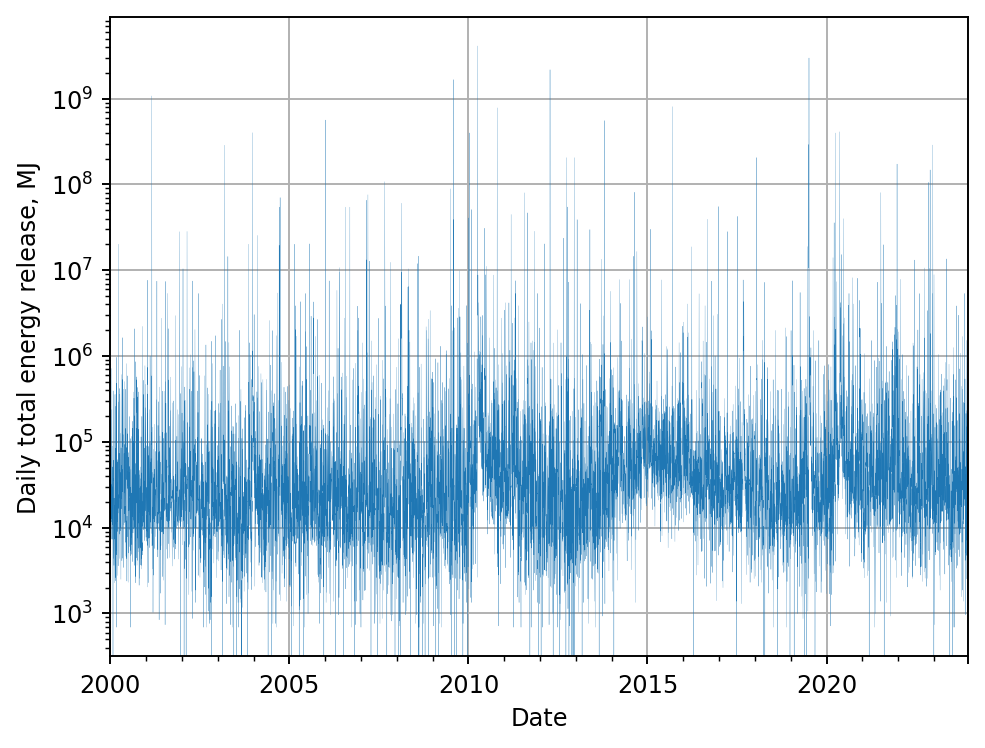

In [27]:
lst_file = [*Path("./data").glob("usgs*.csv")]
tmp_lst = []
for file in lst_file:
    tmp_df = pd.read_csv(file, index_col="time")
    tmp_df.index = pd.DatetimeIndex(tmp_df.index)
    tmp_lst.append(tmp_df)
tmp_df = pd.concat(tmp_lst, axis=0).sort_index()
del tmp_lst
# Eq. from USGS
tmp_df["Energy MJ"] = 10 ** (5.24 + 1.44 * tmp_df.mag) / 1e6
# tmp_df["Energy J"] = 10 ** (4.8 + 1.5 * tmp_df.mag) / 1e6
srs_earthquake = tmp_df["Energy MJ"].groupby(pd.Grouper(freq="D")).sum()
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=173)
srs_earthquake.plot(ax=ax, grid=True, logy=True, lw=0.1)
ax.set_ylabel("Daily total energy release, MJ")
ax.set_xlabel("Date")

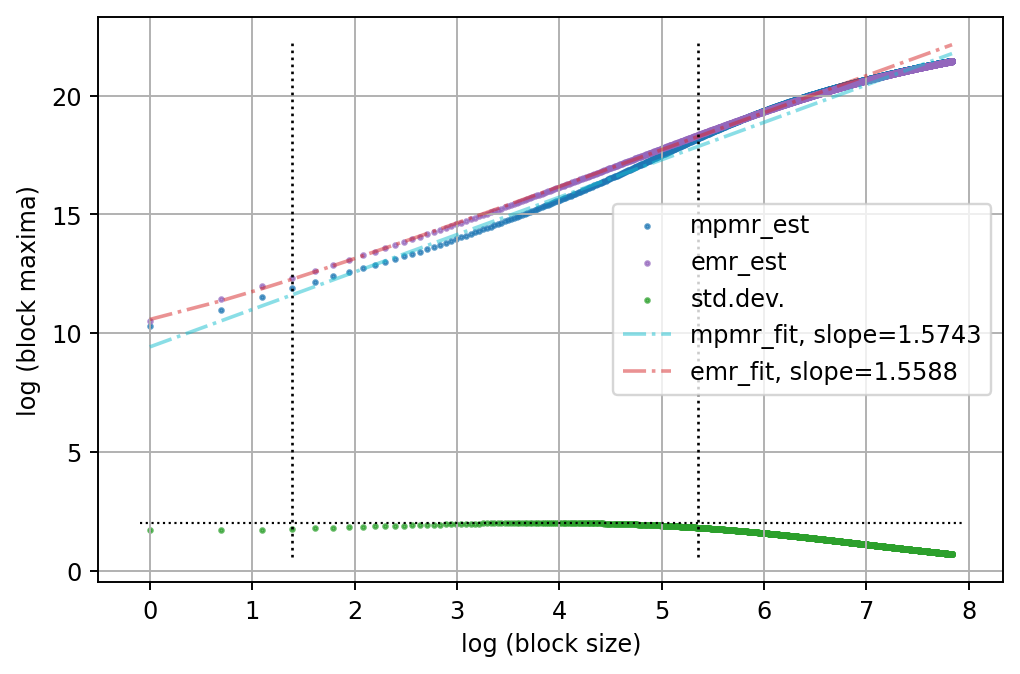

In [28]:
# EVI
dct_res_evi = est_extreme_value_index(
    vec=srs_earthquake,
    is_retn_vec=True,
    delta=0.1,
)
viz_evi_reg(
    dct_res=dct_res_evi,
    is_save=False,
    file_path=DIR_OUT / "evi_earthquake.png",
)

In [29]:
def mj2mag(x):
    return (np.log10(x * 1e6) - 5.24) / 1.44


xi = dct_res_evi["slope_mpmr"]
num_yr = np.array([1, 10, 100]).reshape(1, -1)
num_k = np.array([0, 1, 2]).reshape(-1, 1)
arr = (
    np.log(365.25 * num_yr) * xi
    + dct_res_evi["intercept_mpmr"]
    + dct_res_evi["log_x_min"]
) + (xi * np.pi / np.sqrt(6)) * num_k
df_mag = pd.DataFrame(
    mj2mag(np.exp(arr)),
    columns=num_yr.flatten(),
    index=num_k.flatten(),
)
df_mag.index.name, df_mag.columns.name = "num_k", "num_yr"
# pd.set_option('display.precision', 10)
print(df_mag.round(4))

num_yr     1       10      100
num_k                         
0       6.1727  7.2659  8.3592
1       6.7816  7.8749  8.9682
2       7.3906  8.4838  9.5771


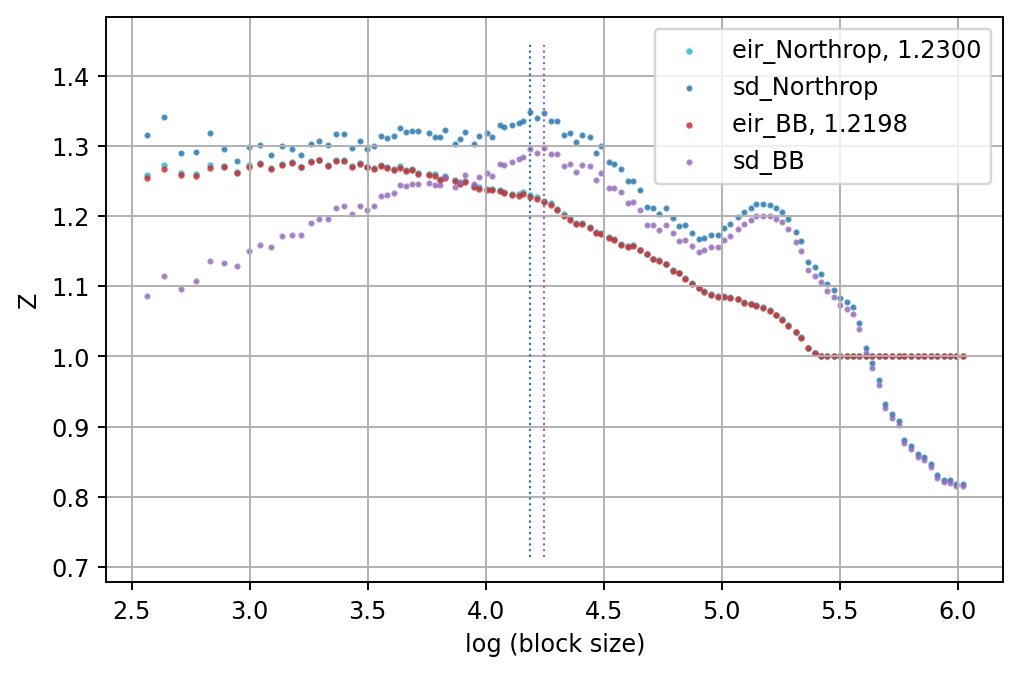

In [19]:
# EI
dct_res_ei = est_extremal_index_reciprocal(srs=srs_earthquake, is_retn_vec=True)
viz_eir(dct_res_ei, is_save=False)

## Sunspot data since 1849

> "Source: WDC-SILSO, Royal Observatory of Belgium, Brussels".
>
> https://www.sidc.be/SILSO/datafiles


In [21]:
df_sunspot = pd.read_csv(
    "https://www.sidc.be/SILSO/INFO/sndtotcsv.php", sep=";", header=None
)
df_sunspot.columns = [
    "year",
    "month",
    "day",
    "date_frac_yr",
    "count_total",
    # "count_north",
    # "count_south",
    "std_total",
    # "std_north",
    # "std_south",
    "num_obs_total",
    # "num_obs_north",
    # "num_obs_south",
    "is_definitive",
]
df_sunspot.index = pd.DatetimeIndex(
    df_sunspot.loc[:, ["year", "month", "day"]].apply(
        lambda srs: f"{srs.year}-{srs.month}-{srs.day}", axis=1
    )
)
print(df_sunspot[df_sunspot["num_obs_total"] < 1])
srs_sunspot = df_sunspot.count_total["1849":].squeeze()

            year  month  day  date_frac_yr  count_total  std_total  \
1818-01-01  1818      1    1      1818.001           -1       -1.0   
1818-01-02  1818      1    2      1818.004           -1       -1.0   
1818-01-03  1818      1    3      1818.007           -1       -1.0   
1818-01-04  1818      1    4      1818.010           -1       -1.0   
1818-01-05  1818      1    5      1818.012           -1       -1.0   
...          ...    ...  ...           ...          ...        ...   
1848-12-05  1848     12    5      1848.928           -1       -1.0   
1848-12-15  1848     12   15      1848.955           -1       -1.0   
1848-12-16  1848     12   16      1848.958           -1       -1.0   
1848-12-19  1848     12   19      1848.966           -1       -1.0   
1848-12-22  1848     12   22      1848.974           -1       -1.0   

            num_obs_total  is_definitive  
1818-01-01              0              1  
1818-01-02              0              1  
1818-01-03              0     

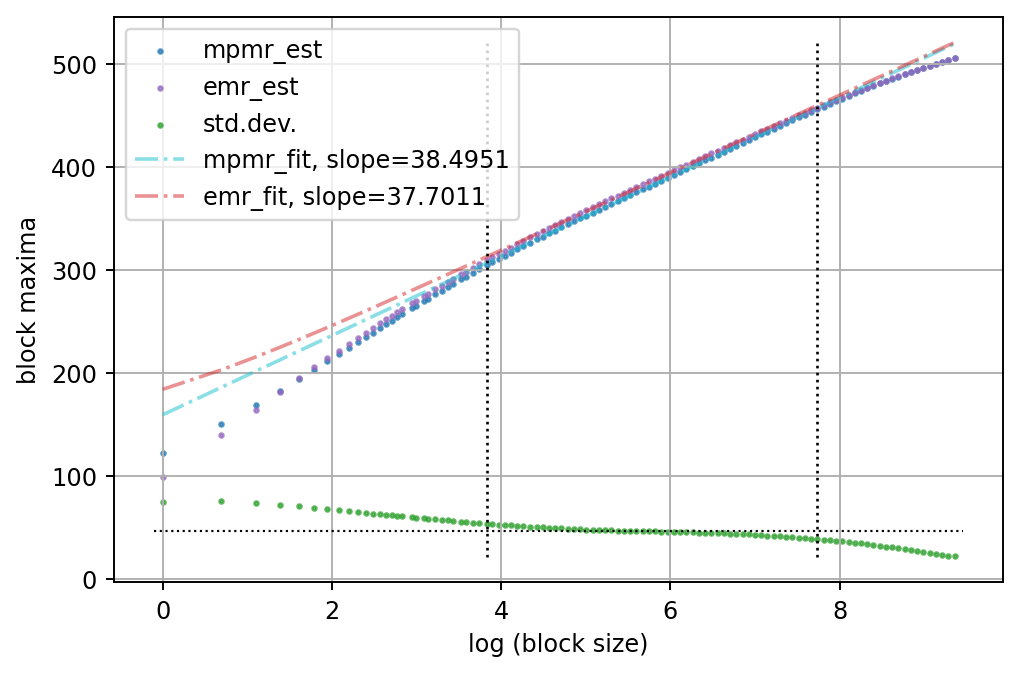

In [50]:
# EVI
dct_res_evi = est_extreme_value_index(
    vec=srs_sunspot.values,
    is_frechet=False,
    is_geom=True,
    is_deming=False,
    is_retn_vec=True,
    delta=0.17,
)
viz_evi_reg(dct_res_evi, is_save=False, file_path=DIR_OUT / "evi_sunspot.png")

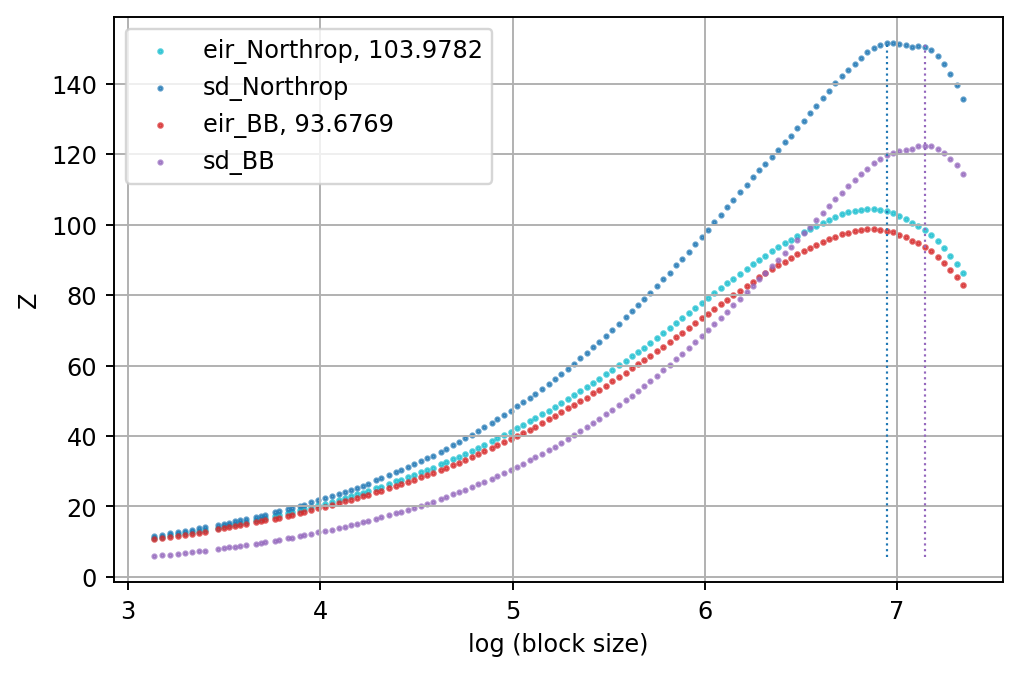

In [7]:
# EI
dct_res_ei = est_extremal_index_reciprocal(
    srs=srs_sunspot, is_retn_vec=True, is_geom=True
)
viz_eir(dct_res=dct_res_ei, is_save=False)

## Greenland land snow cover


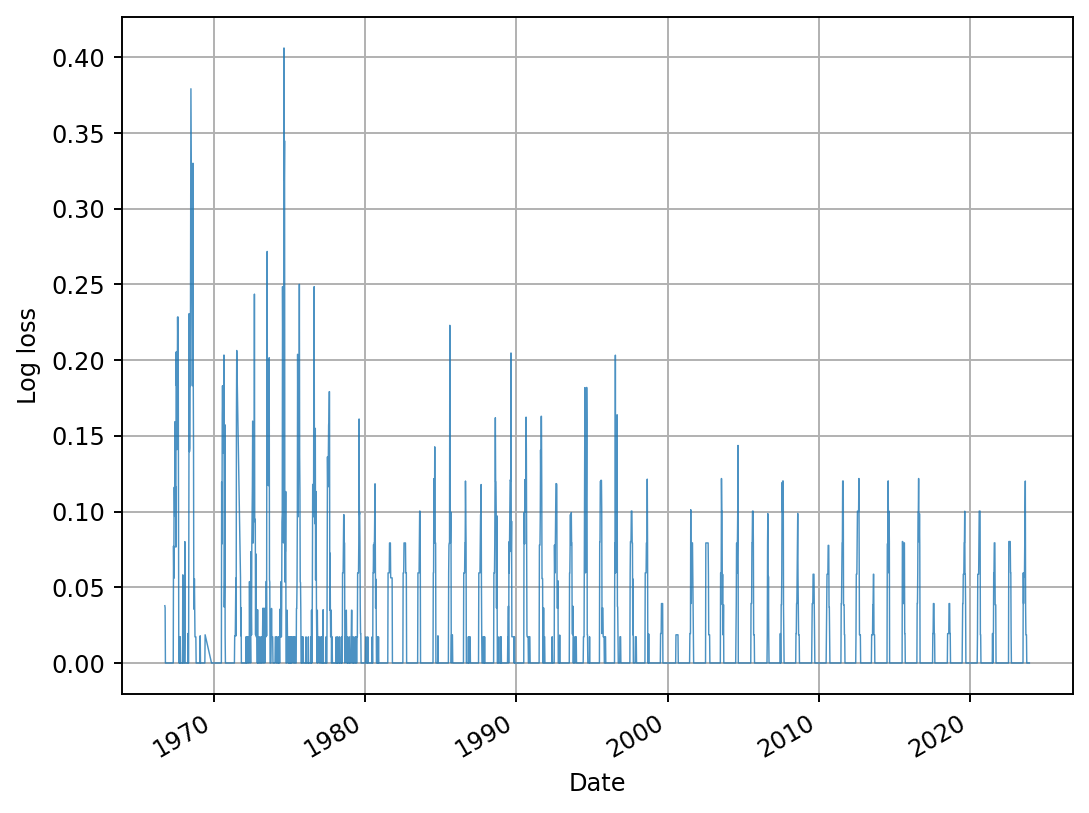

In [66]:
df_snowcover = pd.read_pickle(Path("./data") / "df_snowcover.pkl.gz")
srs_snowcover = df_snowcover["Greenland"]
srs_snowcover = np.log(srs_snowcover.max()) - np.log(srs_snowcover)
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=173)
srs_snowcover.plot(ax=ax, lw=0.6, alpha=0.8, xlabel="Date", ylabel="Log loss")
ax.grid()
fig.tight_layout()

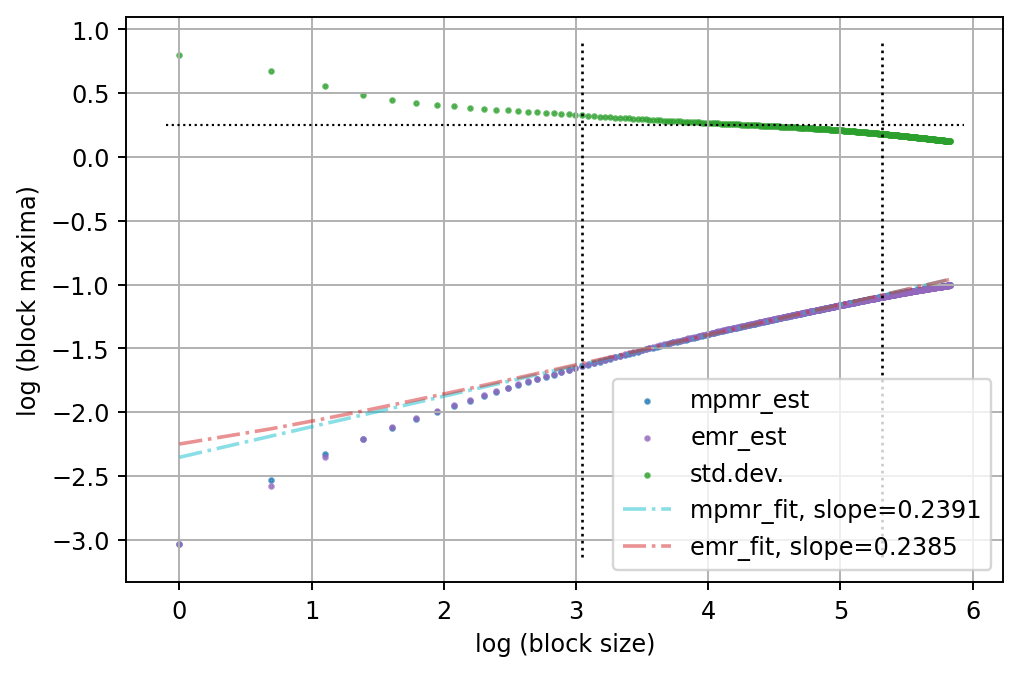

In [67]:
# EVI
dct_res_evi = est_extreme_value_index(
    vec=srs_snowcover.values,
    is_retn_vec=True,
    delta=0.29,
)
viz_evi_reg(
    dct_res=dct_res_evi,
    is_save=False,
    file_path=DIR_OUT / "evi_greenland_land.png",
)

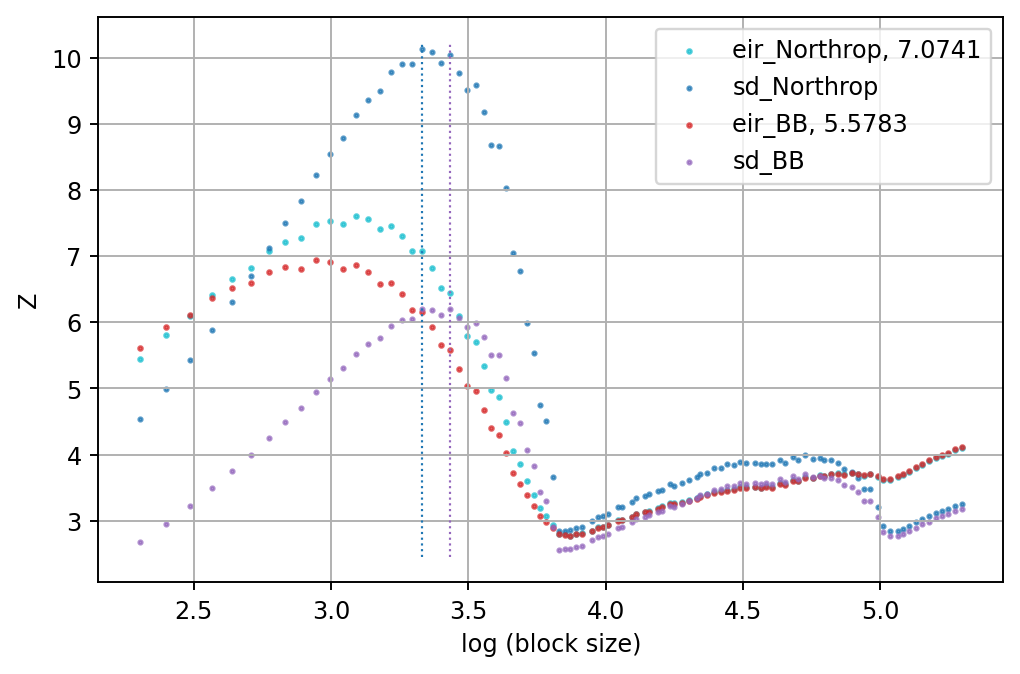

In [23]:
# EI
dct_res_ei = est_extremal_index_reciprocal(srs=tmp_srs, is_retn_vec=True, is_geom=True)
viz_eir(dct_res=dct_res_ei, is_save=False)

## Greenland sea ice extent


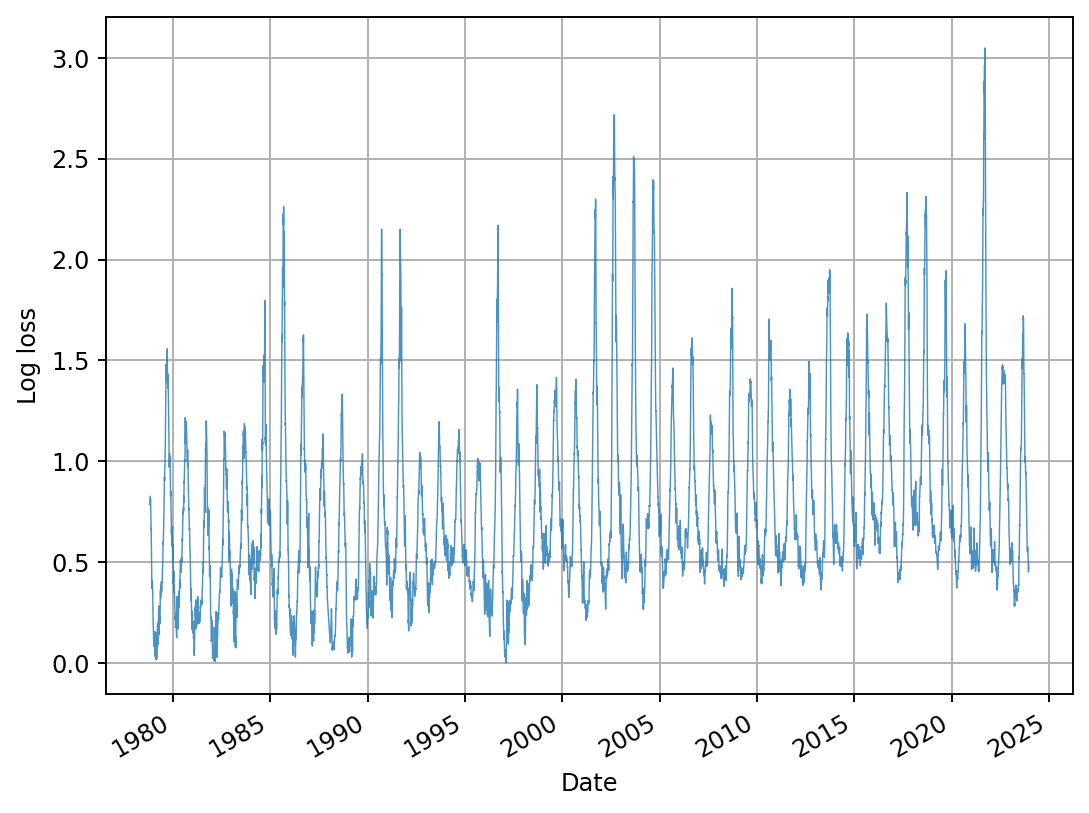

In [140]:
df_sii = pd.read_pickle(Path("./data") / "df_sii.pkl.gz")
srs_sii = df_sii["N_Greenland-Extent-km^2"]
srs_sii = np.log(srs_sii.max()) - np.log(srs_sii)
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=173)
srs_sii.plot(ax=ax, lw=0.6, alpha=0.8, xlabel="Date", ylabel="Log loss")
ax.grid()
fig.tight_layout()

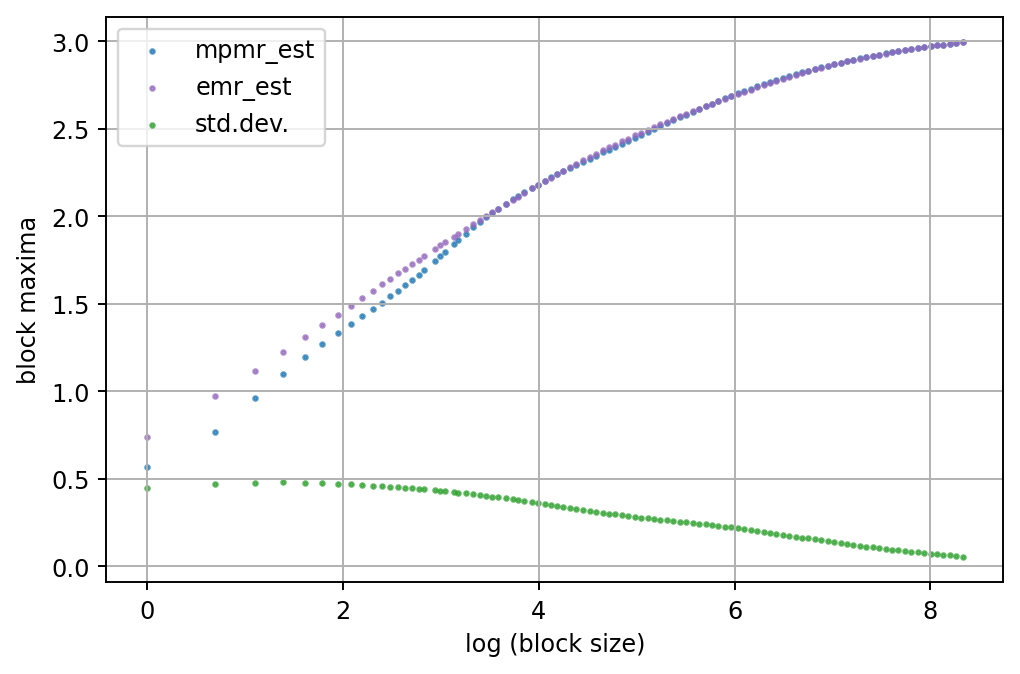

In [169]:
# EVI
dct_res_evi = est_extreme_value_index(
    vec=srs_sii.values,
    is_retn_vec=True,
    is_frechet=False,
    delta=0.29,
)
viz_evi_reg(
    dct_res=dct_res_evi,
    is_save=False,
    file_path=DIR_OUT / "evi_greenland_sea.png",
    is_gaussian=True,
)

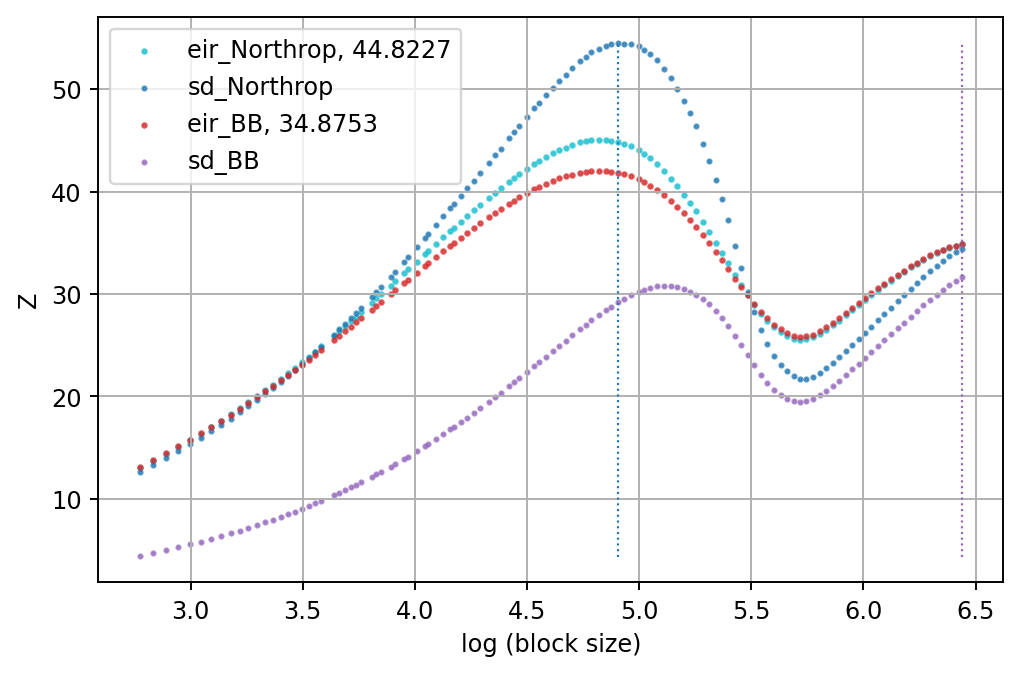

In [27]:
# EI
dct_res_ei = est_extremal_index_reciprocal(srs=tmp_srs, is_retn_vec=True, is_geom=True)
viz_eir(dct_res=dct_res_ei, is_save=False)

##

Copyright (C) 2024- Tuoyuan Cheng, Kan Chen

UniBM is free software: you can redistribute it and/or modify
it under the terms of the GNU Lesser General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

UniBM is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
GNU Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public License
along with UniBM. If not, see <http://www.gnu.org/licenses/>.
